In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
# MNISTデータのダウンロード
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
# 各種行列を生成する関数
def weight_variable(shape, name):
    initial = tf.random_normal(shape,stddev=0.02)
    return tf.Variable(initial, name=name)

def bias_variable(shape, name):
    initial = tf.random_normal(shape, stddev=0.02)
    return tf.Variable(initial, name=name)

In [4]:
def batch_normalizaiton( x, axes=[0] ):
    mean, variance = tf.nn.moments( x, axes )
    return tf.nn.batch_normalization( x, mean, variance, None, None, 1e-5 )

def conv2d(x, W):
    return tf.nn.conv2d(x,W,strides=[1,1,1,1],padding='SAME')

def leaky_relu(input):
    return tf.maximum(0.2*input, input)

In [5]:
batch_size = 100
latent_dim = 100

In [6]:
# generator
g_W1 = weight_variable( [latent_dim, 1024], "g_w1" )
g_b1 = bias_variable( [1024] , "g_b1")
g_W2 = weight_variable( [1024, 128*7*7], "g_w2" )
g_b2 = bias_variable( [128*7*7], "g_b2" )
g_W3 = weight_variable( [5, 5, 64, 128], "g_w3" )
g_b3 = bias_variable( [64], "g_b3" )
g_W4 = weight_variable( [5,5,1,64], "g_w4" )
g_b4 = bias_variable( [1], "g_b4" )

def construct_generater( Z ):
    ## 全結合
    fc1 = tf.matmul( Z, g_W1 ) + g_b1

    ## batch normalization
    bn1 = batch_normalizaiton( fc1 )

    ## relu
    relu1 = tf.nn.relu( bn1 )

    ## 全結合
    fc2 = tf.matmul( relu1, g_W2 ) + g_b2

    ## batch normalization
    bn2 = batch_normalizaiton( fc2 )

    ## relu
    relu2 = tf.nn.relu( bn2 )

    # reshapeで画像化
    y2 = tf.reshape( relu2, [batch_size, 7, 7, 128] )


    ## 転置畳込
    conv_t1 = tf.nn.conv2d_transpose( y2, g_W3, strides=[1,2,2,1], output_shape=[batch_size, 14, 14, 64] ) + g_b3

    ## batch normalization
    bn3 = batch_normalizaiton( conv_t1, [0,1,2] )

    ## relu
    relu3 = tf.nn.relu( bn3 )

    # 転置畳み込み
    conv_t2 = tf.nn.conv2d_transpose( relu3, g_W4, strides=[1,2,2,1], output_shape=[batch_size, 28, 28, 1] ) + g_b4

    # 画像生成
    img = tf.nn.sigmoid( conv_t2 )
    
    return img

In [7]:
import numpy as np

def tensor_to_vector(input):
    shape = input.get_shape()[1:].as_list()
    dim = np.prod(shape)
    print(input.get_shape().as_list())
    print( shape )
    print( dim )
    return tf.reshape(input, [-1, dim]), dim

# discriminatorの重み
d_W1 = weight_variable([5,5,1,64], "d_w1")
d_b1 = bias_variable( [64], "d_b1" )
d_W2 = weight_variable( [5,5,64,128], "d_w2" )
d_b2 = bias_variable( [128], "d_b2" )
d_W3 = weight_variable( [128*7*7, 1024], "d_w3" )
d_b3 = bias_variable( [1024] , "d_b3")
d_W4 = weight_variable([1024, 1], "d_w4")
d_b4 = bias_variable( [1], "d_b4" )
        
def construct_discriminator( img):
        # 畳み込み
        conv1 = tf.nn.conv2d(img, d_W1, strides=[1,2,2,1], padding="SAME") + d_b1

        # leaky relu
        y1 = leaky_relu(conv1)

        # 畳み込み
        conv2 = tf.nn.conv2d(y1, d_W2, strides=[1,2,2,1], padding="SAME") + d_b2

        # leaky leru
        y2 = leaky_relu(conv2)
        
        # ベクトルに直す
        #y2 = tf.reshape( y2, [-1, 7*7*128] )
        
        # 全結合
        vec, _ = tensor_to_vector(y2)
        fc1 = tf.matmul(vec, d_W3) + d_b3

        # leaky relu
        y3 = leaky_relu(fc1)

        # 全結合
        fc2 = tf.matmul(y3, d_W4) + d_b4
        
        return fc2

In [8]:
# モデル構築

# generatorへの入力
Z = tf.placeholder(tf.float32, [batch_size, latent_dim]) 

# Discriminatorが識別する画像
img_real = tf.placeholder(tf.float32, [batch_size, 28, 28, 1]) 
img_gen = construct_generater(Z)

# 本物化偽物化判別
raw_real = construct_discriminator(img_real)
raw_gen = construct_discriminator(img_gen)

# 確率
p_real = tf.nn.sigmoid(raw_real)
p_gen = tf.nn.sigmoid(raw_gen)

# コスト関数
discrim_cost = tf.reduce_mean(-tf.reduce_sum(tf.log(p_real) + tf.log(tf.ones(batch_size, tf.float32) - p_gen), axis=1))
gen_cost = tf.reduce_mean(-tf.reduce_sum(tf.log(p_gen), axis=1))




[100, 7, 7, 128]
[7, 7, 128]
6272
[100, 7, 7, 128]
[7, 7, 128]
6272


In [21]:
discrim_vars = [x for x in tf.trainable_variables() if "d_" in x.name]
gen_vars = [x for x in tf.trainable_variables() if "g_" in x.name]

optimizer_d = tf.train.AdamOptimizer(0.0002, beta1=0.5).minimize(discrim_cost, var_list=discrim_vars)
optimizer_g = tf.train.AdamOptimizer(0.0002, beta1=0.5).minimize(gen_cost, var_list=gen_vars)


0.666706 139.15
0.74361 132.047
0.825986 124.664
0.935912 114.879
1.09687 101.995
1.34232 86.0265
1.70356 68.2878
2.17368 50.858
2.70966 35.5227
3.22966 23.5909
3.69047 15.3142
4.07833 10.0827
4.38957 6.99958
4.63462 5.10597
4.82075 4.04841
4.97771 3.25536
5.09778 2.76617
5.18418 2.49837
5.26941 2.28714
5.35361 2.09356
5.44245 1.89149
5.50881 1.7084
5.54894 1.58709
5.57618 1.45652
5.58216 1.40692
5.59014 1.37502
5.61283 1.32927
5.65884 1.22449
5.68727 1.24188
5.72995 1.27668
5.80881 1.29246
5.91341 1.16069
5.97385 1.1228
5.9844 1.13351
6.0035 1.1846
6.06452 1.20422
6.15615 1.0486
6.14917 1.05791
6.12842 1.24443
6.23294 1.1031
6.29557 1.12832
6.33 1.02349
6.28147 1.00168
6.24022 1.10836
6.3442 1.15255
6.48448 1.07747
6.49777 0.943777
6.362 1.09135
6.4064 0.973961
6.43042 0.965864
6.42366 1.07505
6.50878 1.03061
6.50211 0.93897
6.40328 1.04418
6.48282 1.08175
6.63305 0.968579
6.47688 1.04725
6.52119 1.12476
6.71499 0.912038
6.42934 1.1514
6.74012 0.861338
6.45585 0.937897
6.51446 0.94177

/Users/naka_t/.pyenv/versions/anaconda2-4.4.0/envs/tf140/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


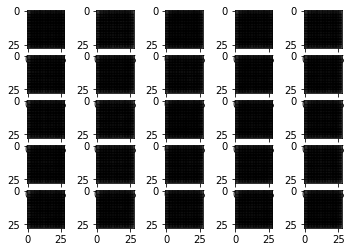

4.93713 2.22365
4.91542 2.24303
4.87143 2.4493
4.8095 2.70102
4.76623 3.02779
4.71648 3.17386
4.62244 3.43604
4.53878 3.64773
4.46875 4.00397
4.40494 4.01852
4.32032 4.37058
4.26207 4.9159
4.20915 5.1197
4.1322 5.36962
4.06457 5.49252
4.00916 5.86754
3.93811 6.27401
3.9203 6.5391
3.87108 6.87252
3.79547 7.08051
3.77181 7.4888
3.7248 7.75191
3.69921 7.9509
3.6997 8.31525
3.59174 8.61657
3.55133 8.99155
3.52222 9.13726
3.44962 9.4398
3.51845 9.91569
3.41229 10.035
3.34178 10.332
3.37762 10.5514
3.30738 10.9942


In [ ]:
itr = 0
n_epochs = 500

# 学習
sess = tf.Session()
sess.run(tf.global_variables_initializer())

for epoch in range(n_epochs):
    images = mnist.test.images
    np.random.shuffle(images)
    N = len(images)


    # batch_size毎のfor
    for start in range(0, N-batch_size, batch_size):
        end = start + batch_size
                     
        # 正規化
        img_bach = images[start:end].reshape([-1, 28,28,1]) / 255.
        random_Z = np.random.uniform(-1,1, size=[batch_size, latent_dim]).astype(np.float32)
        
        feed_dict = {Z: random_Z}
        _, gen_loss = sess.run([optimizer_g, gen_cost], feed_dict=feed_dict) 

        feed_dict = {Z: random_Z, img_real: img_bach}
        _, discrim_loss = sess.run([optimizer_d, discrim_cost], feed_dict=feed_dict)
        
        print(gen_loss, discrim_loss)


        """
        if itr%2==1:
            # 偶数番目はGeneratorを学習
            feed_dict = {Z: random_Z}
            _, gen_loss = sess.run([optimizer_g, gen_cost], feed_dict=feed_dict) 
            #discrim_loss_val, p_real_val, p_gen_val = sess.run([d_cost_tf, p_real, p_gen], feed_dict={Z_tf:Zs, image_tf:Xs})
            #print("=========== updating G ==========")
            #print("iteration:", itr)
            print("gen loss:", gen_loss)
            #print("discrim loss:", discrim_loss_val)
        else:
            # 奇数番目はDiscriminatorを学習
            feed_dict = {Z: random_Z, img_real: img_bach}
            _, discrim_loss = sess.run([optimizer_d, discrim_cost], feed_dict=feed_dict)
            #gen_loss_val, p_real_val, p_gen_val = sess.run([g_cost_tf, p_real, p_gen], 
              #                                             feed_dict={Z_tf:Zs, image_tf:Xs})
            #print("=========== updating D ==========")
            #print("iteration:", itr)
            
            print("disc loss:", discrim_loss)
            #print("discrim loss:", discrim_loss_val)
        """

        #print("Average P(real)=", p_real_val.mean())
        #print("Average P(gen)=", p_gen_val.mean())
        itr += 1
        
    feed_dict = {Z: random_Z}
    img = sess.run( [img_gen], feed_dict=feed_dict  )
    for i in range(25):
        plt.subplot( 5, 5, i+1 )
        plt.imshow( img[0][i].reshape(28,28), cmap="gray" )
    plt.show()
